In [1]:
print("Last updated: $(read(`date`, String))")

Last updated: Mon Aug  3 16:07:47 PDT 2020


In [2]:
# Load environment
import Pkg; Pkg.activate("../../../")

 Activating environment at `~/repo/TuringBnpBenchmarks/Project.toml`


In [3]:
# Import Libraries
using Turing
using Turing: Variational
using Distributions
using Distances
using PyPlot
using StatsFuns
import Random
using Flux
import LinearAlgebra
using JSON3

In [4]:
# For getting quantiles along array dimensions
function quantiles(X, q; dims, drop=false)
  Q = mapslices(x -> quantile(x, q), X, dims=dims)
  out = drop ? dropdims(Q, dims=dims) : Q
  return out
end

# To extract parameters from ADVI model.
function make_extractor(m, q, nsamples=1000)
    qsamples = rand(q, nsamples)
    _, sym2range = Variational.bijector(m; sym_to_ranges = Val(true));
    return sym -> qsamples[collect(sym2range[sym][1]), :]
end
;

In [5]:
# Squared-exponential covariance function
sqexp_cov_fn(D, alpha, rho, eps=1e-3) = alpha ^ 2 * exp.(-0.5 * (D/rho) .^ 2) + LinearAlgebra.I * eps

@model function GP(y, X, cov_fn=sqexp_cov_fn, m_alpha=0.0, s_alpha=1.0, m_rho=0.0, s_rho=1.0)
    # Distance matrix.
    D = pairwise(Distances.Euclidean(), X, dims=1)
    
    # Priors.
    alpha ~ LogNormal(m_alpha, s_alpha)
    rho ~ LogNormal(m_rho, s_rho)
    
    # Realized covariance function
    K = cov_fn(D, alpha, rho)
    
    # Sampling Distribution.
    y ~ MvNormal(K)  # mean=0, covariance=K.
end

DynamicPPL.ModelGen{var"###generator#417",(:y, :X, :cov_fn, :m_alpha, :s_alpha, :m_rho, :s_rho),(:cov_fn, :m_alpha, :s_alpha, :m_rho, :s_rho),Tuple{typeof(sqexp_cov_fn),Float64,Float64,Float64,Float64}}(##generator#417, (cov_fn = sqexp_cov_fn, m_alpha = 0.0, s_alpha = 1.0, m_rho = 0.0, s_rho = 1.0))

In [36]:
# Small dataset
# NOTE: With this dataset, computations *do not* use multiple cores.
#
# data = let
#     json_str = "{\"x\": [-0.498, 1.322, -2.999, -1.186, -2.119, -2.446, -1.882, -0.927, -0.619, 0.233, -0.485, 1.111, -1.773, 2.269, -2.836, 1.023, -0.496, 0.352, -2.158, -1.811, 1.804, 2.81, -1.119, 1.154, 2.258, 2.368, -2.49, -2.766, -1.981, 2.269], \"f\": [0.476, 0.711, 0.059, -0.375, 0.064, 0.557, -0.565, 0.283, 0.557, -0.148, 0.463, 0.171, -0.804, -0.383, 0.239, -0.062, 0.474, -0.3, 0.157, -0.729, 0.743, -0.274, -0.194, 0.288, -0.365, -0.511, 0.562, 0.332, -0.306, -0.383], \"x_true\": [-3.5, -3.493, -3.486, -3.479, -3.472, -3.465, -3.458, -3.451, -3.444, -3.437, -3.43, -3.423, -3.416, -3.409, -3.402, -3.395, -3.388, -3.381, -3.374, -3.367, -3.36, -3.353, -3.346, -3.339, -3.332, -3.325, -3.318, -3.311, -3.304, -3.297, -3.29, -3.283, -3.276, -3.269, -3.262, -3.255, -3.248, -3.241, -3.234, -3.227, -3.22, -3.213, -3.206, -3.199, -3.192, -3.185, -3.178, -3.171, -3.164, -3.157, -3.15, -3.143, -3.136, -3.129, -3.122, -3.115, -3.108, -3.101, -3.094, -3.087, -3.08, -3.073, -3.066, -3.059, -3.052, -3.045, -3.038, -3.031, -3.024, -3.017, -3.01, -3.003, -2.995, -2.988, -2.981, -2.974, -2.967, -2.96, -2.953, -2.946, -2.939, -2.932, -2.925, -2.918, -2.911, -2.904, -2.897, -2.89, -2.883, -2.876, -2.869, -2.862, -2.855, -2.848, -2.841, -2.834, -2.827, -2.82, -2.813, -2.806, -2.799, -2.792, -2.785, -2.778, -2.771, -2.764, -2.757, -2.75, -2.743, -2.736, -2.729, -2.722, -2.715, -2.708, -2.701, -2.694, -2.687, -2.68, -2.673, -2.666, -2.659, -2.652, -2.645, -2.638, -2.631, -2.624, -2.617, -2.61, -2.603, -2.596, -2.589, -2.582, -2.575, -2.568, -2.561, -2.554, -2.547, -2.54, -2.533, -2.526, -2.519, -2.512, -2.505, -2.498, -2.491, -2.484, -2.477, -2.47, -2.463, -2.456, -2.449, -2.442, -2.435, -2.428, -2.421, -2.414, -2.407, -2.4, -2.393, -2.386, -2.379, -2.372, -2.365, -2.358, -2.351, -2.344, -2.337, -2.33, -2.323, -2.316, -2.309, -2.302, -2.295, -2.288, -2.281, -2.274, -2.267, -2.26, -2.253, -2.246, -2.239, -2.232, -2.225, -2.218, -2.211, -2.204, -2.197, -2.19, -2.183, -2.176, -2.169, -2.162, -2.155, -2.148, -2.141, -2.134, -2.127, -2.12, -2.113, -2.106, -2.099, -2.092, -2.085, -2.078, -2.071, -2.064, -2.057, -2.05, -2.043, -2.036, -2.029, -2.022, -2.015, -2.008, -2.001, -1.993, -1.986, -1.979, -1.972, -1.965, -1.958, -1.951, -1.944, -1.937, -1.93, -1.923, -1.916, -1.909, -1.902, -1.895, -1.888, -1.881, -1.874, -1.867, -1.86, -1.853, -1.846, -1.839, -1.832, -1.825, -1.818, -1.811, -1.804, -1.797, -1.79, -1.783, -1.776, -1.769, -1.762, -1.755, -1.748, -1.741, -1.734, -1.727, -1.72, -1.713, -1.706, -1.699, -1.692, -1.685, -1.678, -1.671, -1.664, -1.657, -1.65, -1.643, -1.636, -1.629, -1.622, -1.615, -1.608, -1.601, -1.594, -1.587, -1.58, -1.573, -1.566, -1.559, -1.552, -1.545, -1.538, -1.531, -1.524, -1.517, -1.51, -1.503, -1.496, -1.489, -1.482, -1.475, -1.468, -1.461, -1.454, -1.447, -1.44, -1.433, -1.426, -1.419, -1.412, -1.405, -1.398, -1.391, -1.384, -1.377, -1.37, -1.363, -1.356, -1.349, -1.342, -1.335, -1.328, -1.321, -1.314, -1.307, -1.3, -1.293, -1.286, -1.279, -1.272, -1.265, -1.258, -1.251, -1.244, -1.237, -1.23, -1.223, -1.216, -1.209, -1.202, -1.195, -1.188, -1.181, -1.174, -1.167, -1.16, -1.153, -1.146, -1.139, -1.132, -1.125, -1.118, -1.111, -1.104, -1.097, -1.09, -1.083, -1.076, -1.069, -1.062, -1.055, -1.048, -1.041, -1.034, -1.027, -1.02, -1.013, -1.006, -0.998, -0.991, -0.984, -0.977, -0.97, -0.963, -0.956, -0.949, -0.942, -0.935, -0.928, -0.921, -0.914, -0.907, -0.9, -0.893, -0.886, -0.879, -0.872, -0.865, -0.858, -0.851, -0.844, -0.837, -0.83, -0.823, -0.816, -0.809, -0.802, -0.795, -0.788, -0.781, -0.774, -0.767, -0.76, -0.753, -0.746, -0.739, -0.732, -0.725, -0.718, -0.711, -0.704, -0.697, -0.69, -0.683, -0.676, -0.669, -0.662, -0.655, -0.648, -0.641, -0.634, -0.627, -0.62, -0.613, -0.606, -0.599, -0.592, -0.585, -0.578, -0.571, -0.564, -0.557, -0.55, -0.543, -0.536, -0.529, -0.522, -0.515, -0.508, -0.501, -0.494, -0.487, -0.48, -0.473, -0.466, -0.459, -0.452, -0.445, -0.438, -0.431, -0.424, -0.417, -0.41, -0.403, -0.396, -0.389, -0.382, -0.375, -0.368, -0.361, -0.354, -0.347, -0.34, -0.333, -0.326, -0.319, -0.312, -0.305, -0.298, -0.291, -0.284, -0.277, -0.27, -0.263, -0.256, -0.249, -0.242, -0.235, -0.228, -0.221, -0.214, -0.207, -0.2, -0.193, -0.186, -0.179, -0.172, -0.165, -0.158, -0.151, -0.144, -0.137, -0.13, -0.123, -0.116, -0.109, -0.102, -0.095, -0.088, -0.081, -0.074, -0.067, -0.06, -0.053, -0.046, -0.039, -0.032, -0.025, -0.018, -0.011, -0.004, 0.004, 0.011, 0.018, 0.025, 0.032, 0.039, 0.046, 0.053, 0.06, 0.067, 0.074, 0.081, 0.088, 0.095, 0.102, 0.109, 0.116, 0.123, 0.13, 0.137, 0.144, 0.151, 0.158, 0.165, 0.172, 0.179, 0.186, 0.193, 0.2, 0.207, 0.214, 0.221, 0.228, 0.235, 0.242, 0.249, 0.256, 0.263, 0.27, 0.277, 0.284, 0.291, 0.298, 0.305, 0.312, 0.319, 0.326, 0.333, 0.34, 0.347, 0.354, 0.361, 0.368, 0.375, 0.382, 0.389, 0.396, 0.403, 0.41, 0.417, 0.424, 0.431, 0.438, 0.445, 0.452, 0.459, 0.466, 0.473, 0.48, 0.487, 0.494, 0.501, 0.508, 0.515, 0.522, 0.529, 0.536, 0.543, 0.55, 0.557, 0.564, 0.571, 0.578, 0.585, 0.592, 0.599, 0.606, 0.613, 0.62, 0.627, 0.634, 0.641, 0.648, 0.655, 0.662, 0.669, 0.676, 0.683, 0.69, 0.697, 0.704, 0.711, 0.718, 0.725, 0.732, 0.739, 0.746, 0.753, 0.76, 0.767, 0.774, 0.781, 0.788, 0.795, 0.802, 0.809, 0.816, 0.823, 0.83, 0.837, 0.844, 0.851, 0.858, 0.865, 0.872, 0.879, 0.886, 0.893, 0.9, 0.907, 0.914, 0.921, 0.928, 0.935, 0.942, 0.949, 0.956, 0.963, 0.97, 0.977, 0.984, 0.991, 0.998, 1.006, 1.013, 1.02, 1.027, 1.034, 1.041, 1.048, 1.055, 1.062, 1.069, 1.076, 1.083, 1.09, 1.097, 1.104, 1.111, 1.118, 1.125, 1.132, 1.139, 1.146, 1.153, 1.16, 1.167, 1.174, 1.181, 1.188, 1.195, 1.202, 1.209, 1.216, 1.223, 1.23, 1.237, 1.244, 1.251, 1.258, 1.265, 1.272, 1.279, 1.286, 1.293, 1.3, 1.307, 1.314, 1.321, 1.328, 1.335, 1.342, 1.349, 1.356, 1.363, 1.37, 1.377, 1.384, 1.391, 1.398, 1.405, 1.412, 1.419, 1.426, 1.433, 1.44, 1.447, 1.454, 1.461, 1.468, 1.475, 1.482, 1.489, 1.496, 1.503, 1.51, 1.517, 1.524, 1.531, 1.538, 1.545, 1.552, 1.559, 1.566, 1.573, 1.58, 1.587, 1.594, 1.601, 1.608, 1.615, 1.622, 1.629, 1.636, 1.643, 1.65, 1.657, 1.664, 1.671, 1.678, 1.685, 1.692, 1.699, 1.706, 1.713, 1.72, 1.727, 1.734, 1.741, 1.748, 1.755, 1.762, 1.769, 1.776, 1.783, 1.79, 1.797, 1.804, 1.811, 1.818, 1.825, 1.832, 1.839, 1.846, 1.853, 1.86, 1.867, 1.874, 1.881, 1.888, 1.895, 1.902, 1.909, 1.916, 1.923, 1.93, 1.937, 1.944, 1.951, 1.958, 1.965, 1.972, 1.979, 1.986, 1.993, 2.001, 2.008, 2.015, 2.022, 2.029, 2.036, 2.043, 2.05, 2.057, 2.064, 2.071, 2.078, 2.085, 2.092, 2.099, 2.106, 2.113, 2.12, 2.127, 2.134, 2.141, 2.148, 2.155, 2.162, 2.169, 2.176, 2.183, 2.19, 2.197, 2.204, 2.211, 2.218, 2.225, 2.232, 2.239, 2.246, 2.253, 2.26, 2.267, 2.274, 2.281, 2.288, 2.295, 2.302, 2.309, 2.316, 2.323, 2.33, 2.337, 2.344, 2.351, 2.358, 2.365, 2.372, 2.379, 2.386, 2.393, 2.4, 2.407, 2.414, 2.421, 2.428, 2.435, 2.442, 2.449, 2.456, 2.463, 2.47, 2.477, 2.484, 2.491, 2.498, 2.505, 2.512, 2.519, 2.526, 2.533, 2.54, 2.547, 2.554, 2.561, 2.568, 2.575, 2.582, 2.589, 2.596, 2.603, 2.61, 2.617, 2.624, 2.631, 2.638, 2.645, 2.652, 2.659, 2.666, 2.673, 2.68, 2.687, 2.694, 2.701, 2.708, 2.715, 2.722, 2.729, 2.736, 2.743, 2.75, 2.757, 2.764, 2.771, 2.778, 2.785, 2.792, 2.799, 2.806, 2.813, 2.82, 2.827, 2.834, 2.841, 2.848, 2.855, 2.862, 2.869, 2.876, 2.883, 2.89, 2.897, 2.904, 2.911, 2.918, 2.925, 2.932, 2.939, 2.946, 2.953, 2.96, 2.967, 2.974, 2.981, 2.988, 2.995, 3.003, 3.01, 3.017, 3.024, 3.031, 3.038, 3.045, 3.052, 3.059, 3.066, 3.073, 3.08, 3.087, 3.094, 3.101, 3.108, 3.115, 3.122, 3.129, 3.136, 3.143, 3.15, 3.157, 3.164, 3.171, 3.178, 3.185, 3.192, 3.199, 3.206, 3.213, 3.22, 3.227, 3.234, 3.241, 3.248, 3.255, 3.262, 3.269, 3.276, 3.283, 3.29, 3.297, 3.304, 3.311, 3.318, 3.325, 3.332, 3.339, 3.346, 3.353, 3.36, 3.367, 3.374, 3.381, 3.388, 3.395, 3.402, 3.409, 3.416, 3.423, 3.43, 3.437, 3.444, 3.451, 3.458, 3.465, 3.472, 3.479, 3.486, 3.493, 3.5], \"f_true\": [0.309, 0.299, 0.29, 0.281, 0.271, 0.262, 0.253, 0.244, 0.235, 0.225, 0.216, 0.207, 0.199, 0.19, 0.181, 0.173, 0.164, 0.156, 0.148, 0.14, 0.132, 0.124, 0.117, 0.109, 0.102, 0.095, 0.088, 0.082, 0.076, 0.069, 0.064, 0.058, 0.052, 0.047, 0.042, 0.038, 0.033, 0.029, 0.025, 0.021, 0.018, 0.015, 0.012, 0.01, 0.007, 0.006, 0.004, 0.003, 0.001, 0.001, 0.0, 0.0, 0.0, 0.001, 0.001, 0.002, 0.003, 0.005, 0.007, 0.009, 0.011, 0.014, 0.017, 0.02, 0.024, 0.028, 0.032, 0.036, 0.041, 0.046, 0.051, 0.056, 0.062, 0.068, 0.074, 0.08, 0.086, 0.093, 0.1, 0.107, 0.114, 0.122, 0.13, 0.137, 0.145, 0.153, 0.162, 0.17, 0.179, 0.187, 0.196, 0.205, 0.214, 0.223, 0.232, 0.241, 0.25, 0.259, 0.269, 0.278, 0.287, 0.297, 0.306, 0.315, 0.324, 0.334, 0.343, 0.352, 0.361, 0.37, 0.379, 0.387, 0.396, 0.405, 0.413, 0.421, 0.43, 0.437, 0.445, 0.453, 0.46, 0.468, 0.475, 0.482, 0.488, 0.495, 0.501, 0.507, 0.512, 0.518, 0.523, 0.528, 0.532, 0.537, 0.54, 0.544, 0.547, 0.551, 0.553, 0.556, 0.558, 0.559, 0.561, 0.562, 0.562, 0.562, 0.562, 0.562, 0.561, 0.56, 0.558, 0.556, 0.554, 0.551, 0.548, 0.544, 0.54, 0.536, 0.531, 0.526, 0.521, 0.515, 0.508, 0.502, 0.495, 0.487, 0.479, 0.471, 0.462, 0.453, 0.444, 0.434, 0.424, 0.413, 0.402, 0.391, 0.379, 0.367, 0.355, 0.342, 0.329, 0.316, 0.302, 0.289, 0.274, 0.26, 0.245, 0.23, 0.214, 0.199, 0.183, 0.166, 0.15, 0.133, 0.116, 0.099, 0.082, 0.064, 0.047, 0.029, 0.011, -0.007, -0.026, -0.044, -0.063, -0.081, -0.1, -0.119, -0.138, -0.157, -0.176, -0.195, -0.214, -0.234, -0.253, -0.272, -0.291, -0.31, -0.329, -0.348, -0.367, -0.386, -0.405, -0.424, -0.442, -0.461, -0.479, -0.497, -0.515, -0.533, -0.55, -0.568, -0.585, -0.602, -0.619, -0.635, -0.652, -0.668, -0.684, -0.699, -0.714, -0.729, -0.744, -0.758, -0.772, -0.786, -0.799, -0.812, -0.824, -0.836, -0.848, -0.859, -0.87, -0.881, -0.891, -0.901, -0.91, -0.919, -0.928, -0.936, -0.943, -0.95, -0.957, -0.963, -0.969, -0.974, -0.979, -0.983, -0.987, -0.99, -0.993, -0.995, -0.997, -0.999, -1.0, -1.0, -1.0, -0.999, -0.998, -0.997, -0.995, -0.992, -0.989, -0.986, -0.982, -0.977, -0.972, -0.967, -0.961, -0.955, -0.948, -0.941, -0.933, -0.925, -0.916, -0.907, -0.898, -0.888, -0.877, -0.867, -0.856, -0.844, -0.832, -0.82, -0.807, -0.794, -0.781, -0.767, -0.753, -0.739, -0.724, -0.709, -0.694, -0.678, -0.662, -0.646, -0.63, -0.613, -0.596, -0.579, -0.562, -0.544, -0.527, -0.509, -0.491, -0.472, -0.454, -0.436, -0.417, -0.398, -0.379, -0.361, -0.342, -0.323, -0.303, -0.284, -0.265, -0.246, -0.227, -0.208, -0.189, -0.169, -0.15, -0.131, -0.112, -0.094, -0.075, -0.056, -0.038, -0.019, -0.001, 0.017, 0.035, 0.053, 0.071, 0.088, 0.105, 0.122, 0.139, 0.156, 0.172, 0.188, 0.204, 0.22, 0.235, 0.25, 0.265, 0.279, 0.293, 0.307, 0.321, 0.334, 0.347, 0.359, 0.372, 0.384, 0.395, 0.406, 0.417, 0.427, 0.437, 0.447, 0.456, 0.465, 0.474, 0.482, 0.49, 0.497, 0.504, 0.511, 0.517, 0.523, 0.528, 0.533, 0.538, 0.542, 0.546, 0.549, 0.552, 0.555, 0.557, 0.559, 0.56, 0.561, 0.562, 0.562, 0.562, 0.562, 0.561, 0.56, 0.559, 0.557, 0.555, 0.552, 0.549, 0.546, 0.543, 0.539, 0.535, 0.531, 0.526, 0.521, 0.516, 0.51, 0.505, 0.499, 0.492, 0.486, 0.479, 0.472, 0.465, 0.458, 0.45, 0.443, 0.435, 0.427, 0.418, 0.41, 0.402, 0.393, 0.384, 0.376, 0.367, 0.358, 0.349, 0.339, 0.33, 0.321, 0.312, 0.303, 0.293, 0.284, 0.275, 0.265, 0.256, 0.247, 0.238, 0.229, 0.22, 0.211, 0.202, 0.193, 0.184, 0.176, 0.167, 0.159, 0.151, 0.143, 0.135, 0.127, 0.119, 0.112, 0.105, 0.098, 0.091, 0.084, 0.078, 0.072, 0.066, 0.06, 0.054, 0.049, 0.044, 0.039, 0.035, 0.03, 0.026, 0.023, 0.019, 0.016, 0.013, 0.011, 0.008, 0.006, 0.004, 0.003, 0.002, 0.001, 0.0, 0.0, -0.0, -0.0, -0.001, -0.002, -0.003, -0.004, -0.006, -0.008, -0.011, -0.013, -0.016, -0.019, -0.023, -0.026, -0.03, -0.035, -0.039, -0.044, -0.049, -0.054, -0.06, -0.066, -0.072, -0.078, -0.084, -0.091, -0.098, -0.105, -0.112, -0.119, -0.127, -0.135, -0.143, -0.151, -0.159, -0.167, -0.176, -0.184, -0.193, -0.202, -0.211, -0.22, -0.229, -0.238, -0.247, -0.256, -0.265, -0.275, -0.284, -0.293, -0.303, -0.312, -0.321, -0.33, -0.339, -0.349, -0.358, -0.367, -0.376, -0.384, -0.393, -0.402, -0.41, -0.418, -0.427, -0.435, -0.443, -0.45, -0.458, -0.465, -0.472, -0.479, -0.486, -0.492, -0.499, -0.505, -0.51, -0.516, -0.521, -0.526, -0.531, -0.535, -0.539, -0.543, -0.546, -0.549, -0.552, -0.555, -0.557, -0.559, -0.56, -0.561, -0.562, -0.562, -0.562, -0.562, -0.561, -0.56, -0.559, -0.557, -0.555, -0.552, -0.549, -0.546, -0.542, -0.538, -0.533, -0.528, -0.523, -0.517, -0.511, -0.504, -0.497, -0.49, -0.482, -0.474, -0.465, -0.456, -0.447, -0.437, -0.427, -0.417, -0.406, -0.395, -0.384, -0.372, -0.359, -0.347, -0.334, -0.321, -0.307, -0.293, -0.279, -0.265, -0.25, -0.235, -0.22, -0.204, -0.188, -0.172, -0.156, -0.139, -0.122, -0.105, -0.088, -0.071, -0.053, -0.035, -0.017, 0.001, 0.019, 0.038, 0.056, 0.075, 0.094, 0.112, 0.131, 0.15, 0.169, 0.189, 0.208, 0.227, 0.246, 0.265, 0.284, 0.303, 0.323, 0.342, 0.361, 0.379, 0.398, 0.417, 0.436, 0.454, 0.472, 0.491, 0.509, 0.527, 0.544, 0.562, 0.579, 0.596, 0.613, 0.63, 0.646, 0.662, 0.678, 0.694, 0.709, 0.724, 0.739, 0.753, 0.767, 0.781, 0.794, 0.807, 0.82, 0.832, 0.844, 0.856, 0.867, 0.877, 0.888, 0.898, 0.907, 0.916, 0.925, 0.933, 0.941, 0.948, 0.955, 0.961, 0.967, 0.972, 0.977, 0.982, 0.986, 0.989, 0.992, 0.995, 0.997, 0.998, 0.999, 1.0, 1.0, 1.0, 0.999, 0.997, 0.995, 0.993, 0.99, 0.987, 0.983, 0.979, 0.974, 0.969, 0.963, 0.957, 0.95, 0.943, 0.936, 0.928, 0.919, 0.91, 0.901, 0.891, 0.881, 0.87, 0.859, 0.848, 0.836, 0.824, 0.812, 0.799, 0.786, 0.772, 0.758, 0.744, 0.729, 0.714, 0.699, 0.684, 0.668, 0.652, 0.635, 0.619, 0.602, 0.585, 0.568, 0.55, 0.533, 0.515, 0.497, 0.479, 0.461, 0.442, 0.424, 0.405, 0.386, 0.367, 0.348, 0.329, 0.31, 0.291, 0.272, 0.253, 0.234, 0.214, 0.195, 0.176, 0.157, 0.138, 0.119, 0.1, 0.081, 0.063, 0.044, 0.026, 0.007, -0.011, -0.029, -0.047, -0.064, -0.082, -0.099, -0.116, -0.133, -0.15, -0.166, -0.183, -0.199, -0.214, -0.23, -0.245, -0.26, -0.274, -0.289, -0.302, -0.316, -0.329, -0.342, -0.355, -0.367, -0.379, -0.391, -0.402, -0.413, -0.424, -0.434, -0.444, -0.453, -0.462, -0.471, -0.479, -0.487, -0.495, -0.502, -0.508, -0.515, -0.521, -0.526, -0.531, -0.536, -0.54, -0.544, -0.548, -0.551, -0.554, -0.556, -0.558, -0.56, -0.561, -0.562, -0.562, -0.562, -0.562, -0.562, -0.561, -0.559, -0.558, -0.556, -0.553, -0.551, -0.547, -0.544, -0.54, -0.537, -0.532, -0.528, -0.523, -0.518, -0.512, -0.507, -0.501, -0.495, -0.488, -0.482, -0.475, -0.468, -0.46, -0.453, -0.445, -0.437, -0.43, -0.421, -0.413, -0.405, -0.396, -0.387, -0.379, -0.37, -0.361, -0.352, -0.343, -0.334, -0.324, -0.315, -0.306, -0.297, -0.287, -0.278, -0.269, -0.259, -0.25, -0.241, -0.232, -0.223, -0.214, -0.205, -0.196, -0.187, -0.179, -0.17, -0.162, -0.153, -0.145, -0.137, -0.13, -0.122, -0.114, -0.107, -0.1, -0.093, -0.086, -0.08, -0.074, -0.068, -0.062, -0.056, -0.051, -0.046, -0.041, -0.036, -0.032, -0.028, -0.024, -0.02, -0.017, -0.014, -0.011, -0.009, -0.007, -0.005, -0.003, -0.002, -0.001, -0.001, -0.0, -0.0, -0.0, -0.001, -0.001, -0.003, -0.004, -0.006, -0.007, -0.01, -0.012, -0.015, -0.018, -0.021, -0.025, -0.029, -0.033, -0.038, -0.042, -0.047, -0.052, -0.058, -0.064, -0.069, -0.076, -0.082, -0.088, -0.095, -0.102, -0.109, -0.117, -0.124, -0.132, -0.14, -0.148, -0.156, -0.164, -0.173, -0.181, -0.19, -0.199, -0.207, -0.216, -0.225, -0.235, -0.244, -0.253, -0.262, -0.271, -0.281, -0.29, -0.299, -0.309]}";
#     JSON3.read(json_str, Dict{Symbol, Vector{Float64}})
# end

# Large dataset
# NOTE: With this dataset, ADVI (but not HMC/NUTS) computations use multiple cores.
data = let
    json_str = "{\"x\": [-2.41, -0.473, 2.747, 0.199, 1.151, -1.107, 1.119, 2.008, -2.89, 1.501, 2.933, 1.489, -1.317, 1.736, -2.381, -0.313, 2.452, -1.238, -1.273, -2.22, -2.884, 1.073, -1.73, -1.407, -0.051, -2.68, 0.445, -2.12, 0.536, 1.199, -2.386, -0.516, 1.166, -0.515, -2.7, 0.215, 0.983, 0.089, 2.668, 0.519, 2.42, -2.175, -2.164, 1.844, -0.614, -2.008, 2.565, -0.913, 1.505, 1.356, 2.3, 0.742, 1.506, -0.907, -1.38, 2.375, -0.431, 2.789, 0.981, 0.73, -2.312, 2.697, -0.301, 0.47, -0.551, -1.578, 2.42, 0.442, -2.983, 0.703, -1.04, 0.162, 2.316, -0.856, 2.451, 0.74, -2.905, 2.577, 1.145, 2.984, -1.966, -2.177, 2.596, 1.181, -2.604, 1.533, 1.523, 2.538, 1.269, -2.254, -2.881, -2.843, -2.83, -1.523, 2.16, 0.233, 0.317, 2.052, -2.255, -1.325], \"f\": [0.542, 0.451, -0.356, -0.111, 0.281, -0.159, 0.192, 0.233, 0.17, 0.976, -0.121, 0.967, -0.701, 0.868, 0.522, 0.248, -0.559, -0.513, -0.6, 0.293, 0.178, 0.068, -0.877, -0.869, 0.008, 0.438, -0.418, 0.065, -0.51, 0.409, 0.526, 0.493, 0.322, 0.492, 0.414, -0.129, -0.16, -0.024, -0.451, -0.496, -0.548, 0.197, 0.173, 0.656, 0.555, -0.233, -0.538, 0.309, 0.978, 0.781, -0.431, -0.536, 0.979, 0.322, -0.826, -0.518, 0.402, -0.301, -0.165, -0.543, 0.447, -0.418, 0.232, -0.447, 0.522, -1.0, -0.548, -0.415, 0.073, -0.555, 0.018, -0.076, -0.453, 0.409, -0.559, -0.537, 0.153, -0.531, 0.264, -0.072, -0.347, 0.202, -0.518, 0.361, 0.512, 0.993, 0.989, -0.551, 0.59, 0.358, 0.182, 0.23, 0.246, -0.988, -0.163, -0.149, -0.254, 0.112, 0.359, -0.718], \"x_true\": [-3.5, -3.493, -3.486, -3.479, -3.472, -3.465, -3.458, -3.451, -3.444, -3.437, -3.43, -3.423, -3.416, -3.409, -3.402, -3.395, -3.388, -3.381, -3.374, -3.367, -3.36, -3.353, -3.346, -3.339, -3.332, -3.325, -3.318, -3.311, -3.304, -3.297, -3.29, -3.283, -3.276, -3.269, -3.262, -3.255, -3.248, -3.241, -3.234, -3.227, -3.22, -3.213, -3.206, -3.199, -3.192, -3.185, -3.178, -3.171, -3.164, -3.157, -3.15, -3.143, -3.136, -3.129, -3.122, -3.115, -3.108, -3.101, -3.094, -3.087, -3.08, -3.073, -3.066, -3.059, -3.052, -3.045, -3.038, -3.031, -3.024, -3.017, -3.01, -3.003, -2.995, -2.988, -2.981, -2.974, -2.967, -2.96, -2.953, -2.946, -2.939, -2.932, -2.925, -2.918, -2.911, -2.904, -2.897, -2.89, -2.883, -2.876, -2.869, -2.862, -2.855, -2.848, -2.841, -2.834, -2.827, -2.82, -2.813, -2.806, -2.799, -2.792, -2.785, -2.778, -2.771, -2.764, -2.757, -2.75, -2.743, -2.736, -2.729, -2.722, -2.715, -2.708, -2.701, -2.694, -2.687, -2.68, -2.673, -2.666, -2.659, -2.652, -2.645, -2.638, -2.631, -2.624, -2.617, -2.61, -2.603, -2.596, -2.589, -2.582, -2.575, -2.568, -2.561, -2.554, -2.547, -2.54, -2.533, -2.526, -2.519, -2.512, -2.505, -2.498, -2.491, -2.484, -2.477, -2.47, -2.463, -2.456, -2.449, -2.442, -2.435, -2.428, -2.421, -2.414, -2.407, -2.4, -2.393, -2.386, -2.379, -2.372, -2.365, -2.358, -2.351, -2.344, -2.337, -2.33, -2.323, -2.316, -2.309, -2.302, -2.295, -2.288, -2.281, -2.274, -2.267, -2.26, -2.253, -2.246, -2.239, -2.232, -2.225, -2.218, -2.211, -2.204, -2.197, -2.19, -2.183, -2.176, -2.169, -2.162, -2.155, -2.148, -2.141, -2.134, -2.127, -2.12, -2.113, -2.106, -2.099, -2.092, -2.085, -2.078, -2.071, -2.064, -2.057, -2.05, -2.043, -2.036, -2.029, -2.022, -2.015, -2.008, -2.001, -1.993, -1.986, -1.979, -1.972, -1.965, -1.958, -1.951, -1.944, -1.937, -1.93, -1.923, -1.916, -1.909, -1.902, -1.895, -1.888, -1.881, -1.874, -1.867, -1.86, -1.853, -1.846, -1.839, -1.832, -1.825, -1.818, -1.811, -1.804, -1.797, -1.79, -1.783, -1.776, -1.769, -1.762, -1.755, -1.748, -1.741, -1.734, -1.727, -1.72, -1.713, -1.706, -1.699, -1.692, -1.685, -1.678, -1.671, -1.664, -1.657, -1.65, -1.643, -1.636, -1.629, -1.622, -1.615, -1.608, -1.601, -1.594, -1.587, -1.58, -1.573, -1.566, -1.559, -1.552, -1.545, -1.538, -1.531, -1.524, -1.517, -1.51, -1.503, -1.496, -1.489, -1.482, -1.475, -1.468, -1.461, -1.454, -1.447, -1.44, -1.433, -1.426, -1.419, -1.412, -1.405, -1.398, -1.391, -1.384, -1.377, -1.37, -1.363, -1.356, -1.349, -1.342, -1.335, -1.328, -1.321, -1.314, -1.307, -1.3, -1.293, -1.286, -1.279, -1.272, -1.265, -1.258, -1.251, -1.244, -1.237, -1.23, -1.223, -1.216, -1.209, -1.202, -1.195, -1.188, -1.181, -1.174, -1.167, -1.16, -1.153, -1.146, -1.139, -1.132, -1.125, -1.118, -1.111, -1.104, -1.097, -1.09, -1.083, -1.076, -1.069, -1.062, -1.055, -1.048, -1.041, -1.034, -1.027, -1.02, -1.013, -1.006, -0.998, -0.991, -0.984, -0.977, -0.97, -0.963, -0.956, -0.949, -0.942, -0.935, -0.928, -0.921, -0.914, -0.907, -0.9, -0.893, -0.886, -0.879, -0.872, -0.865, -0.858, -0.851, -0.844, -0.837, -0.83, -0.823, -0.816, -0.809, -0.802, -0.795, -0.788, -0.781, -0.774, -0.767, -0.76, -0.753, -0.746, -0.739, -0.732, -0.725, -0.718, -0.711, -0.704, -0.697, -0.69, -0.683, -0.676, -0.669, -0.662, -0.655, -0.648, -0.641, -0.634, -0.627, -0.62, -0.613, -0.606, -0.599, -0.592, -0.585, -0.578, -0.571, -0.564, -0.557, -0.55, -0.543, -0.536, -0.529, -0.522, -0.515, -0.508, -0.501, -0.494, -0.487, -0.48, -0.473, -0.466, -0.459, -0.452, -0.445, -0.438, -0.431, -0.424, -0.417, -0.41, -0.403, -0.396, -0.389, -0.382, -0.375, -0.368, -0.361, -0.354, -0.347, -0.34, -0.333, -0.326, -0.319, -0.312, -0.305, -0.298, -0.291, -0.284, -0.277, -0.27, -0.263, -0.256, -0.249, -0.242, -0.235, -0.228, -0.221, -0.214, -0.207, -0.2, -0.193, -0.186, -0.179, -0.172, -0.165, -0.158, -0.151, -0.144, -0.137, -0.13, -0.123, -0.116, -0.109, -0.102, -0.095, -0.088, -0.081, -0.074, -0.067, -0.06, -0.053, -0.046, -0.039, -0.032, -0.025, -0.018, -0.011, -0.004, 0.004, 0.011, 0.018, 0.025, 0.032, 0.039, 0.046, 0.053, 0.06, 0.067, 0.074, 0.081, 0.088, 0.095, 0.102, 0.109, 0.116, 0.123, 0.13, 0.137, 0.144, 0.151, 0.158, 0.165, 0.172, 0.179, 0.186, 0.193, 0.2, 0.207, 0.214, 0.221, 0.228, 0.235, 0.242, 0.249, 0.256, 0.263, 0.27, 0.277, 0.284, 0.291, 0.298, 0.305, 0.312, 0.319, 0.326, 0.333, 0.34, 0.347, 0.354, 0.361, 0.368, 0.375, 0.382, 0.389, 0.396, 0.403, 0.41, 0.417, 0.424, 0.431, 0.438, 0.445, 0.452, 0.459, 0.466, 0.473, 0.48, 0.487, 0.494, 0.501, 0.508, 0.515, 0.522, 0.529, 0.536, 0.543, 0.55, 0.557, 0.564, 0.571, 0.578, 0.585, 0.592, 0.599, 0.606, 0.613, 0.62, 0.627, 0.634, 0.641, 0.648, 0.655, 0.662, 0.669, 0.676, 0.683, 0.69, 0.697, 0.704, 0.711, 0.718, 0.725, 0.732, 0.739, 0.746, 0.753, 0.76, 0.767, 0.774, 0.781, 0.788, 0.795, 0.802, 0.809, 0.816, 0.823, 0.83, 0.837, 0.844, 0.851, 0.858, 0.865, 0.872, 0.879, 0.886, 0.893, 0.9, 0.907, 0.914, 0.921, 0.928, 0.935, 0.942, 0.949, 0.956, 0.963, 0.97, 0.977, 0.984, 0.991, 0.998, 1.006, 1.013, 1.02, 1.027, 1.034, 1.041, 1.048, 1.055, 1.062, 1.069, 1.076, 1.083, 1.09, 1.097, 1.104, 1.111, 1.118, 1.125, 1.132, 1.139, 1.146, 1.153, 1.16, 1.167, 1.174, 1.181, 1.188, 1.195, 1.202, 1.209, 1.216, 1.223, 1.23, 1.237, 1.244, 1.251, 1.258, 1.265, 1.272, 1.279, 1.286, 1.293, 1.3, 1.307, 1.314, 1.321, 1.328, 1.335, 1.342, 1.349, 1.356, 1.363, 1.37, 1.377, 1.384, 1.391, 1.398, 1.405, 1.412, 1.419, 1.426, 1.433, 1.44, 1.447, 1.454, 1.461, 1.468, 1.475, 1.482, 1.489, 1.496, 1.503, 1.51, 1.517, 1.524, 1.531, 1.538, 1.545, 1.552, 1.559, 1.566, 1.573, 1.58, 1.587, 1.594, 1.601, 1.608, 1.615, 1.622, 1.629, 1.636, 1.643, 1.65, 1.657, 1.664, 1.671, 1.678, 1.685, 1.692, 1.699, 1.706, 1.713, 1.72, 1.727, 1.734, 1.741, 1.748, 1.755, 1.762, 1.769, 1.776, 1.783, 1.79, 1.797, 1.804, 1.811, 1.818, 1.825, 1.832, 1.839, 1.846, 1.853, 1.86, 1.867, 1.874, 1.881, 1.888, 1.895, 1.902, 1.909, 1.916, 1.923, 1.93, 1.937, 1.944, 1.951, 1.958, 1.965, 1.972, 1.979, 1.986, 1.993, 2.001, 2.008, 2.015, 2.022, 2.029, 2.036, 2.043, 2.05, 2.057, 2.064, 2.071, 2.078, 2.085, 2.092, 2.099, 2.106, 2.113, 2.12, 2.127, 2.134, 2.141, 2.148, 2.155, 2.162, 2.169, 2.176, 2.183, 2.19, 2.197, 2.204, 2.211, 2.218, 2.225, 2.232, 2.239, 2.246, 2.253, 2.26, 2.267, 2.274, 2.281, 2.288, 2.295, 2.302, 2.309, 2.316, 2.323, 2.33, 2.337, 2.344, 2.351, 2.358, 2.365, 2.372, 2.379, 2.386, 2.393, 2.4, 2.407, 2.414, 2.421, 2.428, 2.435, 2.442, 2.449, 2.456, 2.463, 2.47, 2.477, 2.484, 2.491, 2.498, 2.505, 2.512, 2.519, 2.526, 2.533, 2.54, 2.547, 2.554, 2.561, 2.568, 2.575, 2.582, 2.589, 2.596, 2.603, 2.61, 2.617, 2.624, 2.631, 2.638, 2.645, 2.652, 2.659, 2.666, 2.673, 2.68, 2.687, 2.694, 2.701, 2.708, 2.715, 2.722, 2.729, 2.736, 2.743, 2.75, 2.757, 2.764, 2.771, 2.778, 2.785, 2.792, 2.799, 2.806, 2.813, 2.82, 2.827, 2.834, 2.841, 2.848, 2.855, 2.862, 2.869, 2.876, 2.883, 2.89, 2.897, 2.904, 2.911, 2.918, 2.925, 2.932, 2.939, 2.946, 2.953, 2.96, 2.967, 2.974, 2.981, 2.988, 2.995, 3.003, 3.01, 3.017, 3.024, 3.031, 3.038, 3.045, 3.052, 3.059, 3.066, 3.073, 3.08, 3.087, 3.094, 3.101, 3.108, 3.115, 3.122, 3.129, 3.136, 3.143, 3.15, 3.157, 3.164, 3.171, 3.178, 3.185, 3.192, 3.199, 3.206, 3.213, 3.22, 3.227, 3.234, 3.241, 3.248, 3.255, 3.262, 3.269, 3.276, 3.283, 3.29, 3.297, 3.304, 3.311, 3.318, 3.325, 3.332, 3.339, 3.346, 3.353, 3.36, 3.367, 3.374, 3.381, 3.388, 3.395, 3.402, 3.409, 3.416, 3.423, 3.43, 3.437, 3.444, 3.451, 3.458, 3.465, 3.472, 3.479, 3.486, 3.493, 3.5], \"f_true\": [0.309, 0.299, 0.29, 0.281, 0.271, 0.262, 0.253, 0.244, 0.235, 0.225, 0.216, 0.207, 0.199, 0.19, 0.181, 0.173, 0.164, 0.156, 0.148, 0.14, 0.132, 0.124, 0.117, 0.109, 0.102, 0.095, 0.088, 0.082, 0.076, 0.069, 0.064, 0.058, 0.052, 0.047, 0.042, 0.038, 0.033, 0.029, 0.025, 0.021, 0.018, 0.015, 0.012, 0.01, 0.007, 0.006, 0.004, 0.003, 0.001, 0.001, 0.0, 0.0, 0.0, 0.001, 0.001, 0.002, 0.003, 0.005, 0.007, 0.009, 0.011, 0.014, 0.017, 0.02, 0.024, 0.028, 0.032, 0.036, 0.041, 0.046, 0.051, 0.056, 0.062, 0.068, 0.074, 0.08, 0.086, 0.093, 0.1, 0.107, 0.114, 0.122, 0.13, 0.137, 0.145, 0.153, 0.162, 0.17, 0.179, 0.187, 0.196, 0.205, 0.214, 0.223, 0.232, 0.241, 0.25, 0.259, 0.269, 0.278, 0.287, 0.297, 0.306, 0.315, 0.324, 0.334, 0.343, 0.352, 0.361, 0.37, 0.379, 0.387, 0.396, 0.405, 0.413, 0.421, 0.43, 0.437, 0.445, 0.453, 0.46, 0.468, 0.475, 0.482, 0.488, 0.495, 0.501, 0.507, 0.512, 0.518, 0.523, 0.528, 0.532, 0.537, 0.54, 0.544, 0.547, 0.551, 0.553, 0.556, 0.558, 0.559, 0.561, 0.562, 0.562, 0.562, 0.562, 0.562, 0.561, 0.56, 0.558, 0.556, 0.554, 0.551, 0.548, 0.544, 0.54, 0.536, 0.531, 0.526, 0.521, 0.515, 0.508, 0.502, 0.495, 0.487, 0.479, 0.471, 0.462, 0.453, 0.444, 0.434, 0.424, 0.413, 0.402, 0.391, 0.379, 0.367, 0.355, 0.342, 0.329, 0.316, 0.302, 0.289, 0.274, 0.26, 0.245, 0.23, 0.214, 0.199, 0.183, 0.166, 0.15, 0.133, 0.116, 0.099, 0.082, 0.064, 0.047, 0.029, 0.011, -0.007, -0.026, -0.044, -0.063, -0.081, -0.1, -0.119, -0.138, -0.157, -0.176, -0.195, -0.214, -0.234, -0.253, -0.272, -0.291, -0.31, -0.329, -0.348, -0.367, -0.386, -0.405, -0.424, -0.442, -0.461, -0.479, -0.497, -0.515, -0.533, -0.55, -0.568, -0.585, -0.602, -0.619, -0.635, -0.652, -0.668, -0.684, -0.699, -0.714, -0.729, -0.744, -0.758, -0.772, -0.786, -0.799, -0.812, -0.824, -0.836, -0.848, -0.859, -0.87, -0.881, -0.891, -0.901, -0.91, -0.919, -0.928, -0.936, -0.943, -0.95, -0.957, -0.963, -0.969, -0.974, -0.979, -0.983, -0.987, -0.99, -0.993, -0.995, -0.997, -0.999, -1.0, -1.0, -1.0, -0.999, -0.998, -0.997, -0.995, -0.992, -0.989, -0.986, -0.982, -0.977, -0.972, -0.967, -0.961, -0.955, -0.948, -0.941, -0.933, -0.925, -0.916, -0.907, -0.898, -0.888, -0.877, -0.867, -0.856, -0.844, -0.832, -0.82, -0.807, -0.794, -0.781, -0.767, -0.753, -0.739, -0.724, -0.709, -0.694, -0.678, -0.662, -0.646, -0.63, -0.613, -0.596, -0.579, -0.562, -0.544, -0.527, -0.509, -0.491, -0.472, -0.454, -0.436, -0.417, -0.398, -0.379, -0.361, -0.342, -0.323, -0.303, -0.284, -0.265, -0.246, -0.227, -0.208, -0.189, -0.169, -0.15, -0.131, -0.112, -0.094, -0.075, -0.056, -0.038, -0.019, -0.001, 0.017, 0.035, 0.053, 0.071, 0.088, 0.105, 0.122, 0.139, 0.156, 0.172, 0.188, 0.204, 0.22, 0.235, 0.25, 0.265, 0.279, 0.293, 0.307, 0.321, 0.334, 0.347, 0.359, 0.372, 0.384, 0.395, 0.406, 0.417, 0.427, 0.437, 0.447, 0.456, 0.465, 0.474, 0.482, 0.49, 0.497, 0.504, 0.511, 0.517, 0.523, 0.528, 0.533, 0.538, 0.542, 0.546, 0.549, 0.552, 0.555, 0.557, 0.559, 0.56, 0.561, 0.562, 0.562, 0.562, 0.562, 0.561, 0.56, 0.559, 0.557, 0.555, 0.552, 0.549, 0.546, 0.543, 0.539, 0.535, 0.531, 0.526, 0.521, 0.516, 0.51, 0.505, 0.499, 0.492, 0.486, 0.479, 0.472, 0.465, 0.458, 0.45, 0.443, 0.435, 0.427, 0.418, 0.41, 0.402, 0.393, 0.384, 0.376, 0.367, 0.358, 0.349, 0.339, 0.33, 0.321, 0.312, 0.303, 0.293, 0.284, 0.275, 0.265, 0.256, 0.247, 0.238, 0.229, 0.22, 0.211, 0.202, 0.193, 0.184, 0.176, 0.167, 0.159, 0.151, 0.143, 0.135, 0.127, 0.119, 0.112, 0.105, 0.098, 0.091, 0.084, 0.078, 0.072, 0.066, 0.06, 0.054, 0.049, 0.044, 0.039, 0.035, 0.03, 0.026, 0.023, 0.019, 0.016, 0.013, 0.011, 0.008, 0.006, 0.004, 0.003, 0.002, 0.001, 0.0, 0.0, -0.0, -0.0, -0.001, -0.002, -0.003, -0.004, -0.006, -0.008, -0.011, -0.013, -0.016, -0.019, -0.023, -0.026, -0.03, -0.035, -0.039, -0.044, -0.049, -0.054, -0.06, -0.066, -0.072, -0.078, -0.084, -0.091, -0.098, -0.105, -0.112, -0.119, -0.127, -0.135, -0.143, -0.151, -0.159, -0.167, -0.176, -0.184, -0.193, -0.202, -0.211, -0.22, -0.229, -0.238, -0.247, -0.256, -0.265, -0.275, -0.284, -0.293, -0.303, -0.312, -0.321, -0.33, -0.339, -0.349, -0.358, -0.367, -0.376, -0.384, -0.393, -0.402, -0.41, -0.418, -0.427, -0.435, -0.443, -0.45, -0.458, -0.465, -0.472, -0.479, -0.486, -0.492, -0.499, -0.505, -0.51, -0.516, -0.521, -0.526, -0.531, -0.535, -0.539, -0.543, -0.546, -0.549, -0.552, -0.555, -0.557, -0.559, -0.56, -0.561, -0.562, -0.562, -0.562, -0.562, -0.561, -0.56, -0.559, -0.557, -0.555, -0.552, -0.549, -0.546, -0.542, -0.538, -0.533, -0.528, -0.523, -0.517, -0.511, -0.504, -0.497, -0.49, -0.482, -0.474, -0.465, -0.456, -0.447, -0.437, -0.427, -0.417, -0.406, -0.395, -0.384, -0.372, -0.359, -0.347, -0.334, -0.321, -0.307, -0.293, -0.279, -0.265, -0.25, -0.235, -0.22, -0.204, -0.188, -0.172, -0.156, -0.139, -0.122, -0.105, -0.088, -0.071, -0.053, -0.035, -0.017, 0.001, 0.019, 0.038, 0.056, 0.075, 0.094, 0.112, 0.131, 0.15, 0.169, 0.189, 0.208, 0.227, 0.246, 0.265, 0.284, 0.303, 0.323, 0.342, 0.361, 0.379, 0.398, 0.417, 0.436, 0.454, 0.472, 0.491, 0.509, 0.527, 0.544, 0.562, 0.579, 0.596, 0.613, 0.63, 0.646, 0.662, 0.678, 0.694, 0.709, 0.724, 0.739, 0.753, 0.767, 0.781, 0.794, 0.807, 0.82, 0.832, 0.844, 0.856, 0.867, 0.877, 0.888, 0.898, 0.907, 0.916, 0.925, 0.933, 0.941, 0.948, 0.955, 0.961, 0.967, 0.972, 0.977, 0.982, 0.986, 0.989, 0.992, 0.995, 0.997, 0.998, 0.999, 1.0, 1.0, 1.0, 0.999, 0.997, 0.995, 0.993, 0.99, 0.987, 0.983, 0.979, 0.974, 0.969, 0.963, 0.957, 0.95, 0.943, 0.936, 0.928, 0.919, 0.91, 0.901, 0.891, 0.881, 0.87, 0.859, 0.848, 0.836, 0.824, 0.812, 0.799, 0.786, 0.772, 0.758, 0.744, 0.729, 0.714, 0.699, 0.684, 0.668, 0.652, 0.635, 0.619, 0.602, 0.585, 0.568, 0.55, 0.533, 0.515, 0.497, 0.479, 0.461, 0.442, 0.424, 0.405, 0.386, 0.367, 0.348, 0.329, 0.31, 0.291, 0.272, 0.253, 0.234, 0.214, 0.195, 0.176, 0.157, 0.138, 0.119, 0.1, 0.081, 0.063, 0.044, 0.026, 0.007, -0.011, -0.029, -0.047, -0.064, -0.082, -0.099, -0.116, -0.133, -0.15, -0.166, -0.183, -0.199, -0.214, -0.23, -0.245, -0.26, -0.274, -0.289, -0.302, -0.316, -0.329, -0.342, -0.355, -0.367, -0.379, -0.391, -0.402, -0.413, -0.424, -0.434, -0.444, -0.453, -0.462, -0.471, -0.479, -0.487, -0.495, -0.502, -0.508, -0.515, -0.521, -0.526, -0.531, -0.536, -0.54, -0.544, -0.548, -0.551, -0.554, -0.556, -0.558, -0.56, -0.561, -0.562, -0.562, -0.562, -0.562, -0.562, -0.561, -0.559, -0.558, -0.556, -0.553, -0.551, -0.547, -0.544, -0.54, -0.537, -0.532, -0.528, -0.523, -0.518, -0.512, -0.507, -0.501, -0.495, -0.488, -0.482, -0.475, -0.468, -0.46, -0.453, -0.445, -0.437, -0.43, -0.421, -0.413, -0.405, -0.396, -0.387, -0.379, -0.37, -0.361, -0.352, -0.343, -0.334, -0.324, -0.315, -0.306, -0.297, -0.287, -0.278, -0.269, -0.259, -0.25, -0.241, -0.232, -0.223, -0.214, -0.205, -0.196, -0.187, -0.179, -0.17, -0.162, -0.153, -0.145, -0.137, -0.13, -0.122, -0.114, -0.107, -0.1, -0.093, -0.086, -0.08, -0.074, -0.068, -0.062, -0.056, -0.051, -0.046, -0.041, -0.036, -0.032, -0.028, -0.024, -0.02, -0.017, -0.014, -0.011, -0.009, -0.007, -0.005, -0.003, -0.002, -0.001, -0.001, -0.0, -0.0, -0.0, -0.001, -0.001, -0.003, -0.004, -0.006, -0.007, -0.01, -0.012, -0.015, -0.018, -0.021, -0.025, -0.029, -0.033, -0.038, -0.042, -0.047, -0.052, -0.058, -0.064, -0.069, -0.076, -0.082, -0.088, -0.095, -0.102, -0.109, -0.117, -0.124, -0.132, -0.14, -0.148, -0.156, -0.164, -0.173, -0.181, -0.19, -0.199, -0.207, -0.216, -0.225, -0.235, -0.244, -0.253, -0.262, -0.271, -0.281, -0.29, -0.299, -0.309]}";
    JSON3.read(json_str, Dict{Symbol, Vector{Float64}})
end

Dict{Symbol,Array{Float64,1}} with 4 entries:
  :f      => [0.542, 0.451, -0.356, -0.111, 0.281, -0.159, 0.192, 0.233, 0.17, …
  :f_true => [0.309, 0.299, 0.29, 0.281, 0.271, 0.262, 0.253, 0.244, 0.235, 0.2…
  :x_true => [-3.5, -3.493, -3.486, -3.479, -3.472, -3.465, -3.458, -3.451, -3.…
  :x      => [-2.41, -0.473, 2.747, 0.199, 1.151, -1.107, 1.119, 2.008, -2.89, …

In [37]:
# Reshape data if needed.
y = data[:f]
X = reshape(data[:x], length(y), 1)
N = size(X, 1);

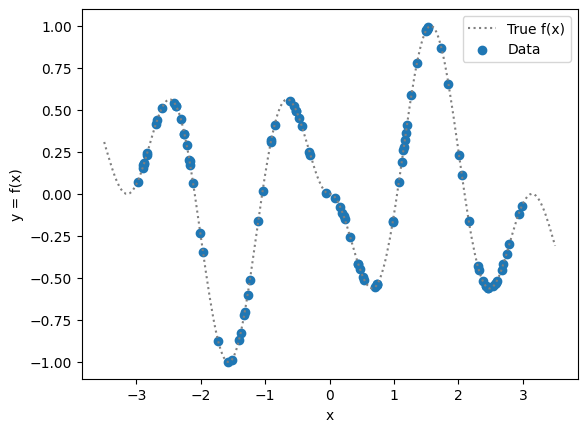

In [38]:
# Plot data
plt.scatter(data[:x], data[:f], label="Data")
plt.plot(data[:x_true], data[:f_true], c="grey", ls=":", label="True f(x)")
plt.xlabel("x")
plt.ylabel("y = f(x)")
plt.legend();

In [39]:
# Fit via ADVI. You can also use HMC.
Random.seed!(0)

m = GP(y, X, sqexp_cov_fn, 0.0, 1.0, -2.0, 0.1)
q0 = Variational.meanfield(m)  # initialize variational distribution (optional)

# NOTE: ADVI(num_elbo_samples, max_iters)

# Compile
@time q = vi(m, ADVI(1, 1), q0, optimizer=Flux.ADAM(1e-1));

# RUN
@time q = vi(m, ADVI(1, 2000), q0, optimizer=Flux.ADAM(1e-1));

# Get posterior samples
extract_gp = make_extractor(m, q)
alpha = vec(extract_gp(:alpha));
rho = vec(extract_gp(:rho));
advi_samples = Dict(:alpha => alpha, :rho => rho)

  0.003724 seconds (571 allocations: 3.853 MiB)


[ADVI] Optimizing...: 100%|█████████████████████████████████████████| Time: 0:00:07


  7.574708 seconds (907.54 k allocations: 7.514 GiB, 7.76% gc time)


Dict{Symbol,Array{Float64,1}} with 2 entries:
  :alpha => [0.34998, 0.321717, 0.339766, 0.291876, 0.389377, 0.406817, 0.35151…
  :rho   => [0.212398, 0.218577, 0.243353, 0.259576, 0.188876, 0.175685, 0.2673…

In [9]:
# Fit via HMC.
Random.seed!(0)
burn = 1000
nsamples = 1000

# Compile
@time _ = sample(m, HMC(0.01, 1), 1)

# Run
@time chain = sample(m, HMC(0.01, 100), burn + nsamples)

# Get posterior samples
alpha = vec(group(chain, :alpha).value.data[end-nsamples:end, :, 1]);
rho = vec(group(chain, :rho).value.data[end-nsamples:end, :, 1]);
hmc_samples = Dict(:alpha => alpha, :rho => rho)

 13.383037 seconds (30.40 M allocations: 1.528 GiB, 4.19% gc time)


Sampling: 100%|█████████████████████████████████████████| Time: 0:02:51


171.678720 seconds (12.43 M allocations: 377.971 GiB, 9.71% gc time)


Dict{Symbol,Array{Float64,1}} with 2 entries:
  :alpha => [0.273876, 0.363773, 0.385649, 0.322497, 0.38653, 0.419673, 0.40199…
  :rho   => [0.234605, 0.244685, 0.248821, 0.245745, 0.250962, 0.253722, 0.2528…

In [18]:
# Fit via NUTS.
Random.seed!(7)

# Compile
@time _ = sample(m, NUTS(4, 0.8), 9);

# Run
@time chain = begin
    nsamples = 1000  # number of MCMC samples
    nadapt = 1000  # number of iterations to adapt tuning parameters in NUTS
    iterations = nsamples + nadapt
    target_accept_ratio = 0.8
    
    sample(m, NUTS(nadapt, target_accept_ratio, max_depth=10), iterations);
end

# Get posterior samples
alpha = vec(group(chain, :alpha).value.data[:, :, 1]);
rho = vec(group(chain, :rho).value.data[:, :, 1]);
nuts_samples = Dict(:alpha => alpha, :rho => rho);

  0.204819 seconds (14.16 k allocations: 300.474 MiB, 8.61% gc time)


┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/ubuntu/.julia/packages/Turing/NZ9IU/src/inference/hmc.jl:629
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/ubuntu/.julia/packages/Turing/NZ9IU/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:10


 10.514039 seconds (1.50 M allocations: 21.838 GiB, 11.11% gc time)


In [12]:
# This funciton returns a function for predicting at new points given parameter values.
function make_gp_predict_fn(Xnew, y, X, cov_fn)
    N = size(X, 1)
    M = size(Xnew, 1)
    Q = N + M
    Z = [Xnew; X]
    D = pairwise(Euclidean(), Z, dims=1)
    
    return (alpha, rho) -> let
        K = cov_fn(D, alpha, rho)
        Koo_inv = inv(K[(M+1):end, (M+1):end])
        Knn = K[1:M, 1:M]
        Kno = K[1:M, (M+1):end]
        C = Kno * Koo_inv
        m = C * y
        S = Matrix(LinearAlgebra.Hermitian(Knn - C * Kno'))
        mvn = MvNormal(m, S)
        rand(mvn)
    end
end

make_gp_predict_fn (generic function with 1 method)

In [13]:
# Function for plotting parameter posterior.
function plot_post(samples, name; bins=nothing, suffix="")
    param = samples[name]
    plt.hist(param, density=true, bins=bins)
    plt.xlabel(name)
    plt.ylabel("density")
    if suffix !== ""
        suffix = "($(suffix))"
    end
    plt.title("Histogram of $(name) $(suffix)");
end

plot_post (generic function with 1 method)

In [14]:
function plot_fn_posterior(samples; figsize=(12, 4), figsize_f=figsize, suffix="")
    # Get parameters
    alpha = samples[:alpha]
    rho = samples[:rho]
   
    # Plot parameters posterior.
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plot_post(samples, :alpha, bins=30, suffix=suffix)
    plt.subplot(1, 2, 2)
    plot_post(samples, :rho, bins=30, suffix=suffix)
    
    # Make predictions at new locations.
    X_new = reshape(collect(range(-3.5, 3.5, length=100)), 100, 1)
    gp_predict = make_gp_predict_fn(X_new, y, X, sqexp_cov_fn)
    ynew = [gp_predict(alpha[m], rho[m]) for m in 1:length(alpha)]
    ynew = hcat(ynew...);

    # Summary statistics of posterior function.
    pred_mean = mean(ynew, dims=2)
    pred_lower = quantiles(ynew, 0.025, dims=2)
    pred_upper = quantiles(ynew, 0.975, dims=2)
    
    if suffix !== ""
        suffix = "($(suffix))"
    end 
     
    # Plot predictions.
    plt.figure(figsize=figsize_f)
    plt.plot(vec(X_new), vec(pred_mean), color="blue", label="Posterior predictive mean")
    plt.plot(data[:x_true], data[:f_true], color="black", ls=":", label="True f(x)")
    plt.scatter(vec(X), vec(y), color="grey", label="Data")
    plt.fill_between(vec(X_new), vec(pred_upper), vec(pred_lower), color="blue", alpha=0.1)
    plt.legend(loc="upper left")
    plt.title("GP Posterior predictive with 95% credible interval $(suffix)");
end

plot_fn_posterior (generic function with 1 method)

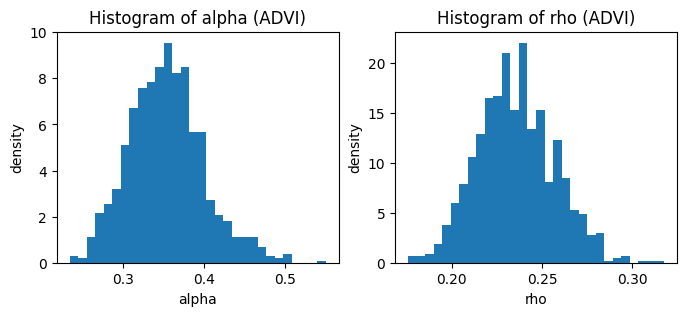

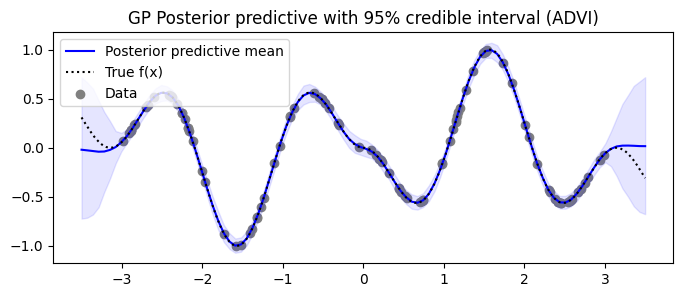

In [15]:
plot_fn_posterior(advi_samples, figsize=(8, 3), suffix="ADVI");

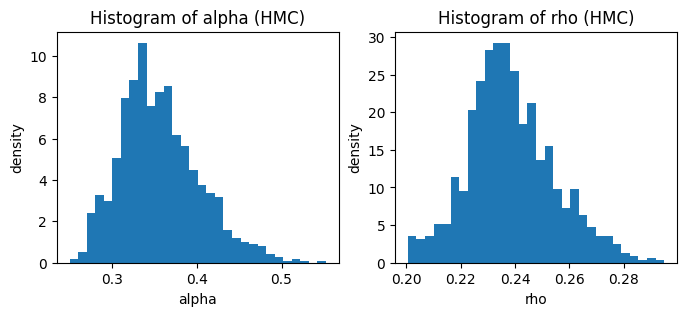

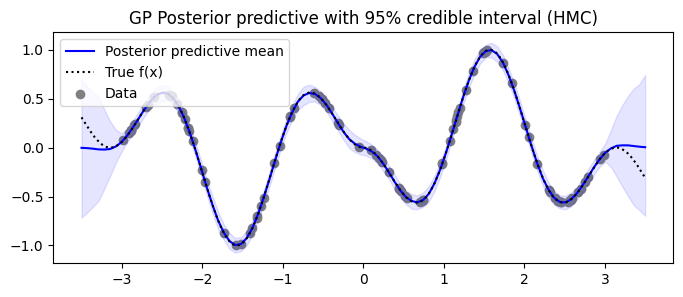

In [16]:
plot_fn_posterior(hmc_samples, figsize=(8, 3), suffix="HMC");

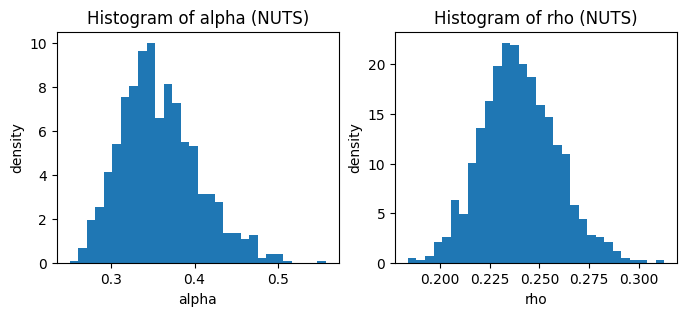

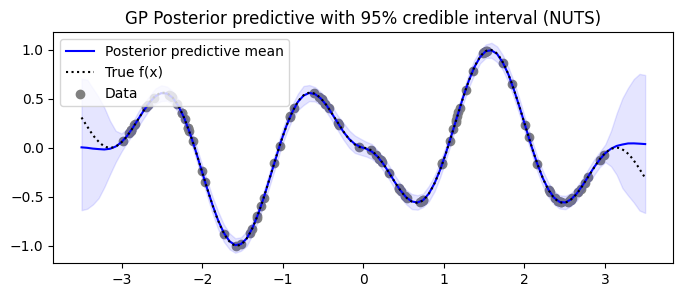

In [17]:
plot_fn_posterior(nuts_samples, figsize=(8, 3), suffix="NUTS");